<a href="https://colab.research.google.com/github/tonytao465/2024Spring/blob/main/SMA_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [ ]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

# Decision Variables

In [ ]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 200

# Utility (Actual Usage)

In [ ]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [ ]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,104,104,200,2.54,1288.59,3086.55
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,22,22,200,2.54,673.59,140.99
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,50,50,200,2.54,883.59,579.23


In [ ]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [ ]:
calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, 1288)

CaLNG price: $7.50
---
Peak intake from pipeline: 200 MMcf
Total peak months intake from pipeline: 12,942 MMcf
Total intake from CaLNG: 774 MMcf
---
Total amount paid to pipeline: $23,100,991
Total amount paid to CaLNG: $9,660,000
Total cost for utility: $32,760,991
Savings from using CaLNG: $11,298,570
---
Total cost if average draw daily: $15,342,871


# Option

In [ ]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

In [ ]:
# simulate demand data
sim_demand_data = demand_data.copy()

# generate sample
demand_sample = np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data))
demand_sample = np.round(np.where(demand_sample < 0, 0, demand_sample),0)

sim_demand_data['Demand'] = demand_sample
sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake_from_pipeline, total_lng)

calculate_cost_statistics(sim_usage_data, calng_price, peak_intake_from_pipeline, total_lng)

CaLNG price: $7.50
---
Peak intake from pipeline: 180 MMcf
Total peak months intake from pipeline: 12,322 MMcf
Total intake from CaLNG: 839 MMcf
---
Total amount paid to pipeline: $16,820,030
Total amount paid to CaLNG: $9,000,000
Total cost for utility: $25,820,030
Savings from using CaLNG: $6,465,168
---
Total cost if average draw daily: $13,299,115


# Option Optimization
In progress

In [ ]:
# number of simulation draws per scenario
num_draws = 5000
# decision variables
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range= range(170,200,5)

all_demand_samples = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, (num_draws, len(demand_data))))
all_demand_samples[all_demand_samples < 0] = 0

cost_stat_list = []
df = pd.DataFrame()
total_iterations = len(total_lng_range) * len(peak_intake_from_pipeline_range) * num_draws


with tqdm(total=total_iterations, desc="Overall Progress") as pbar:
    cost_stat_list = []

    for total in total_lng_range:
        for peak in peak_intake_from_pipeline_range:
            sims = []
            for n in range(num_draws):
                sim_demand_data = demand_data.copy()
                sim_demand_data['Demand'] = all_demand_samples[n]

                sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak, total)
                cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak, total, return_data=True)

                sims.append(cost_stat_dict)


                pbar.update(1)

            cost_stats_average = {key: np.mean([d[key] for d in sims]) for key in sims[0]}
            cost_stats_std_dev = {key + '_std_dev': np.std([d[key] for d in sims], ddof=1) for key in sims[0]}


            cost_stats = {**cost_stats_average, **cost_stats_std_dev}

            cost_stat_list.append(cost_stats)

    df = pd.DataFrame(cost_stat_list)



Overall Progress: 100%|██████████| 360000/360000 [3:23:46<00:00, 29.44it/s]


In [ ]:
min_cost_index = df['total_utility_cost'].idxmin()
min_cost_index

best_total_lng_purchase = df['total_lng_purchase'].iloc[min_cost_index]
best_total_utility_cost = df['total_utility_cost'].iloc[min_cost_index]
best_total_lng_purchase = df['total_lng_purchase'].iloc[min_cost_index]
best_peak_intake = df['peak_intake_from_pipeline'].iloc[min_cost_index]

print("Best values:")
print(f"Peak Intake from Pipeline: {best_peak_intake}")
print(f"Total LNG Purchase: {best_total_lng_purchase}")
print(f"Lowest total utility_cost: {best_total_utility_cost}")

Best values:
Peak Intake from Pipeline: 180.0
Total LNG Purchase: 900.0
Lowest total utility_cost: 25111215.529285315


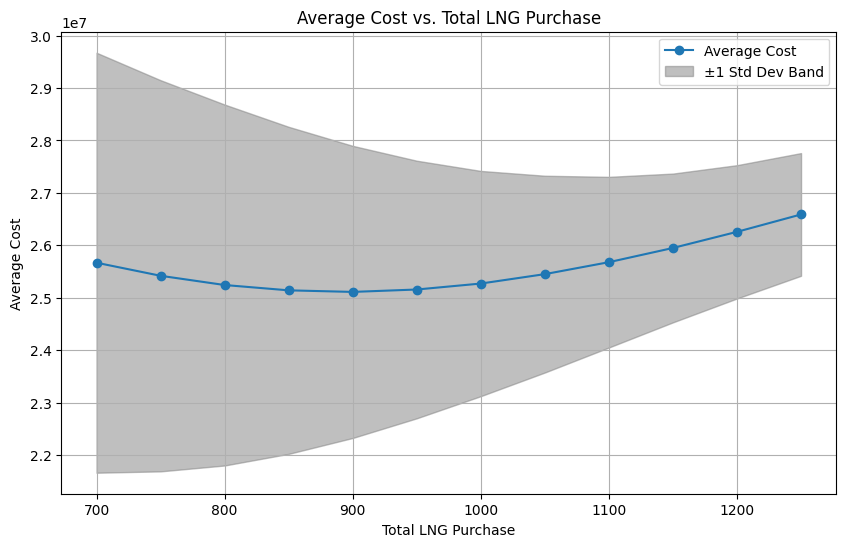

In [ ]:
df1 = df[df['peak_intake_from_pipeline'] == best_peak_intake]


plt.figure(figsize=(10, 6))
plt.plot(df1['total_lng_purchase'], df1['total_utility_cost'], '-o', label='Average Cost')
plt.fill_between(df1['total_lng_purchase'],
                 df1['total_utility_cost'] - df1['total_utility_cost_std_dev'],
                 df1['total_utility_cost'] + df1['total_utility_cost_std_dev'],
                 color='gray', alpha=0.5, label='±1 Std Dev Band')
plt.xlabel('Total LNG Purchase')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Total LNG Purchase')
plt.legend()
plt.grid(True)
plt.show()

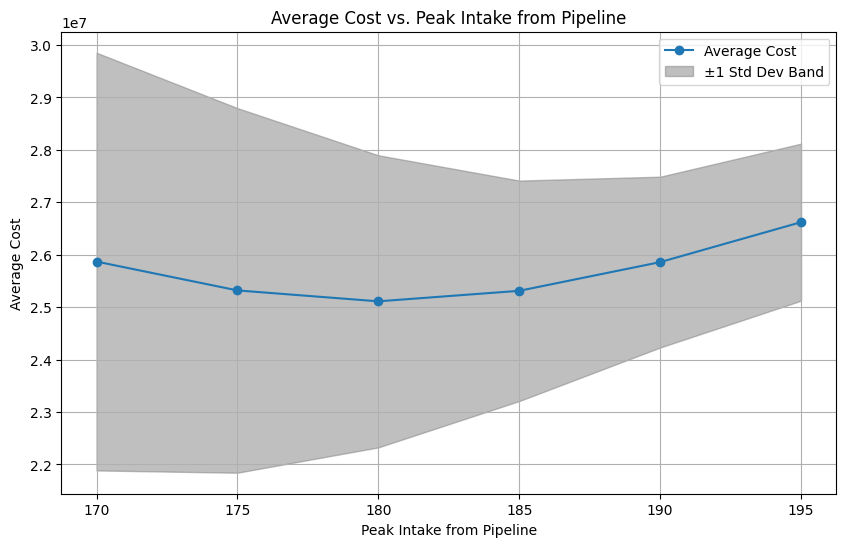

In [ ]:
df2 = df[df['total_lng_purchase'] == best_total_lng_purchase]


plt.figure(figsize=(10, 6))
plt.plot(df2['peak_intake_from_pipeline'], df2['total_utility_cost'], '-o', label='Average Cost')
plt.fill_between(df2['peak_intake_from_pipeline'],
                 df2['total_utility_cost'] - df2['total_utility_cost_std_dev'],
                 df2['total_utility_cost'] + df2['total_utility_cost_std_dev'],
                 color='gray', alpha=0.5, label='±1 Std Dev Band')
plt.xlabel('Peak Intake from Pipeline')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Peak Intake from Pipeline')
plt.legend()
plt.grid(True)
plt.show()

